In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 3 # batch size for training and evaluation

Now, let's investigate what is inside the archive.

In [2]:
dataset_root_path = "/mnt/JaHiD/Zahid/RnD/VideoMAEClassification/VideoMAE/UCF101"

In [3]:
import pathlib, os
os.environ['WANDB_DISABLED']='true'

dataset_root_path = pathlib.Path(dataset_root_path)

In [4]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 13451


In [5]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('/mnt/JaHiD/Zahid/RnD/VideoMAEClassification/VideoMAE/UCF101/train/Typing/v_Typing_g11_c01.avi'),
 PosixPath('/mnt/JaHiD/Zahid/RnD/VideoMAEClassification/VideoMAE/UCF101/train/Typing/v_Typing_g02_c05.avi'),
 PosixPath('/mnt/JaHiD/Zahid/RnD/VideoMAEClassification/VideoMAE/UCF101/train/Typing/v_Typing_g20_c04.avi'),
 PosixPath('/mnt/JaHiD/Zahid/RnD/VideoMAEClassification/VideoMAE/UCF101/train/Typing/v_Typing_g07_c02.avi'),
 PosixPath('/mnt/JaHiD/Zahid/RnD/VideoMAEClassification/VideoMAE/UCF101/train/Typing/v_Typing_g04_c02.avi')]

In [6]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'HammerThrow', 'Hammering', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'P

In [7]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [9]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [10]:
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(10055, 1673, 1723)

Let's now take a preprocessed video from the dataset and investigate it.

In [11]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [12]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_CricketBowling_g25_c04.avi
video_index 2400
clip_index 0
aug_index 0
label 22
Video label: CricketBowling


In [13]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

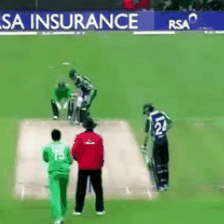

In [14]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

In [15]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-hd"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
import evaluate
metric = evaluate.load("accuracy")

In [17]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [18]:
import torch
def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

In [20]:
train_results = trainer.train()

  0%|          | 0/13404 [00:00<?, ?it/s]

{'loss': 4.7071, 'learning_rate': 3.7285607755406413e-07, 'epoch': 0.0}
{'loss': 4.6431, 'learning_rate': 7.457121551081283e-07, 'epoch': 0.0}
{'loss': 4.706, 'learning_rate': 1.1185682326621925e-06, 'epoch': 0.0}
{'loss': 4.5747, 'learning_rate': 1.4914243102162565e-06, 'epoch': 0.0}
{'loss': 4.5507, 'learning_rate': 1.864280387770321e-06, 'epoch': 0.0}
{'loss': 4.6891, 'learning_rate': 2.237136465324385e-06, 'epoch': 0.0}
{'loss': 4.7366, 'learning_rate': 2.6099925428784492e-06, 'epoch': 0.01}
{'loss': 4.6691, 'learning_rate': 2.982848620432513e-06, 'epoch': 0.01}
{'loss': 4.7648, 'learning_rate': 3.3557046979865773e-06, 'epoch': 0.01}
{'loss': 4.7858, 'learning_rate': 3.728560775540642e-06, 'epoch': 0.01}
{'loss': 4.7392, 'learning_rate': 4.101416853094705e-06, 'epoch': 0.01}
{'loss': 4.5647, 'learning_rate': 4.47427293064877e-06, 'epoch': 0.01}
{'loss': 4.6875, 'learning_rate': 4.847129008202834e-06, 'epoch': 0.01}
{'loss': 4.6498, 'learning_rate': 5.2199850857568985e-06, 'epoch': 

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [22]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.1726735234260559,
 'eval_accuracy': 0.9535402718604179,
 'eval_runtime': 691.0268,
 'eval_samples_per_second': 7.133,
 'eval_steps_per_second': 2.378,
 'epoch': 3.25}

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`.

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)